# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Creación del dataframe de un contador

Leemos el fichero

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Ficheros/lecturas.csv')

df.groupby('num_serie').count()

,fecha_lectura,volumen_m3
num_serie,,
P15UF026599X,1269,1269
P17AD500894X,1148,1148
P18UE027252X,965,965
P19AC793309X,516,516


Seleccionamos el contador deseado

In [5]:
contador = df[df['num_serie'] == 'P15UF026599X'	].drop('num_serie', axis = 1)
contador['fecha_lectura'] = pd.to_datetime(contador['fecha_lectura'])

Calculamos el consumo de cada dia

In [6]:
lectura =  contador['volumen_m3'].to_numpy('float64')

lista_consumo = []

longitud = len(lectura)-1

for i in range(0,longitud):
    diferencia = lectura[i+1] - lectura[i]
    lista_consumo.append(diferencia)

lista_consumo.insert(0,sum(consumo)/len(consumo))

contador['consumo'] = lista_consumo

contador['consumo']

NameError: ignored

# Gráficos del contador

Visualizamos una gráfica con el consumo de todos los días sin los que faltan.

<BarContainer object of 1269 artists>

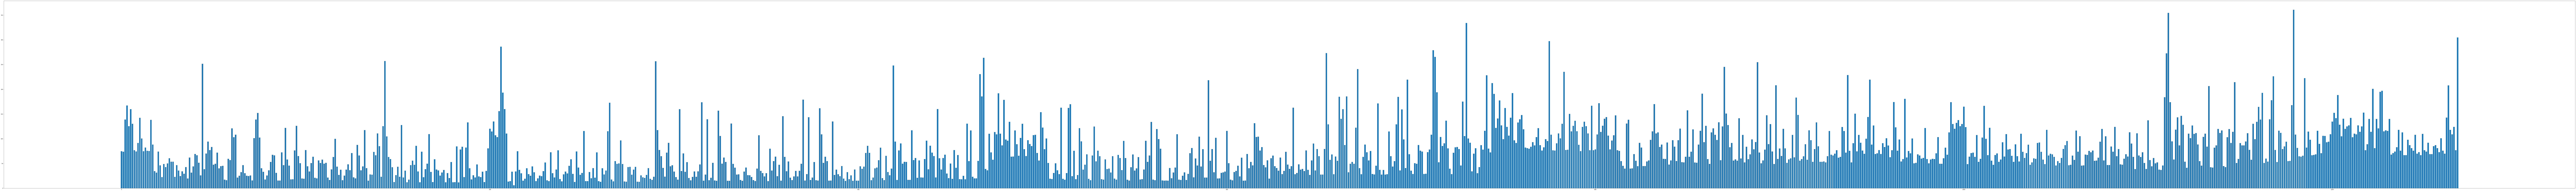

In [ ]:
fig, ax = plt.subplots(figsize = (400,30))

ax.bar(x=range(0,len(contador['consumo'])),height=contador['consumo'])

Calculamos los dias que faltan en nuestro contador, para ello cogeremos todas las fechas y crearemos una frequencia de dia en dia, lo cual nos dará todos los dias desde el primero hasta el último, con ellos vamos comprobando si esos dias están en las fechas de lectura y si no están significa que se ha perdido y es lo que tenemos que calcular.

In [ ]:
contador.set_index('fecha_lectura',inplace=True)
indice = contador.asfreq("d").index.to_numpy()

dias_faltantes = []

for i in indice:
  if i not in pd.to_datetime(contador.index):
    dias_faltantes.append(i)

contador_d = contador.to_dict()

for dia in dias_faltantes:
  contador_d['volumen_m3'][dia] = np.nan
  contador_d['consumo'][dia] = np.nan

contador = pd.DataFrame(contador_d)

contador.index.name = 'fecha_lectura'


In [ ]:
contador.sort_index(inplace=True)
contador.tail(10)

,volumen_m3,consumo
fecha_lectura,,
2021-03-16 00:00:00,105113.0,143.0
2021-03-17 00:00:00,105321.0,208.0
2021-03-18 00:00:00,105439.0,118.0
2021-03-19 00:00:00,105548.0,109.0
2021-03-20 00:00:00,105672.0,124.0
2021-03-21 00:00:00,105749.0,77.0
2021-03-22T00:00:00.000000000,NaN,NaN
2021-03-23T00:00:00.000000000,NaN,NaN
2021-03-24T00:00:00.000000000,NaN,NaN


## Visualizamos el consumo del contador con los dias faltantes

Podemos observar que al final de la gráfica hay un hueco, lo que indica que son los dias que nos faltan.

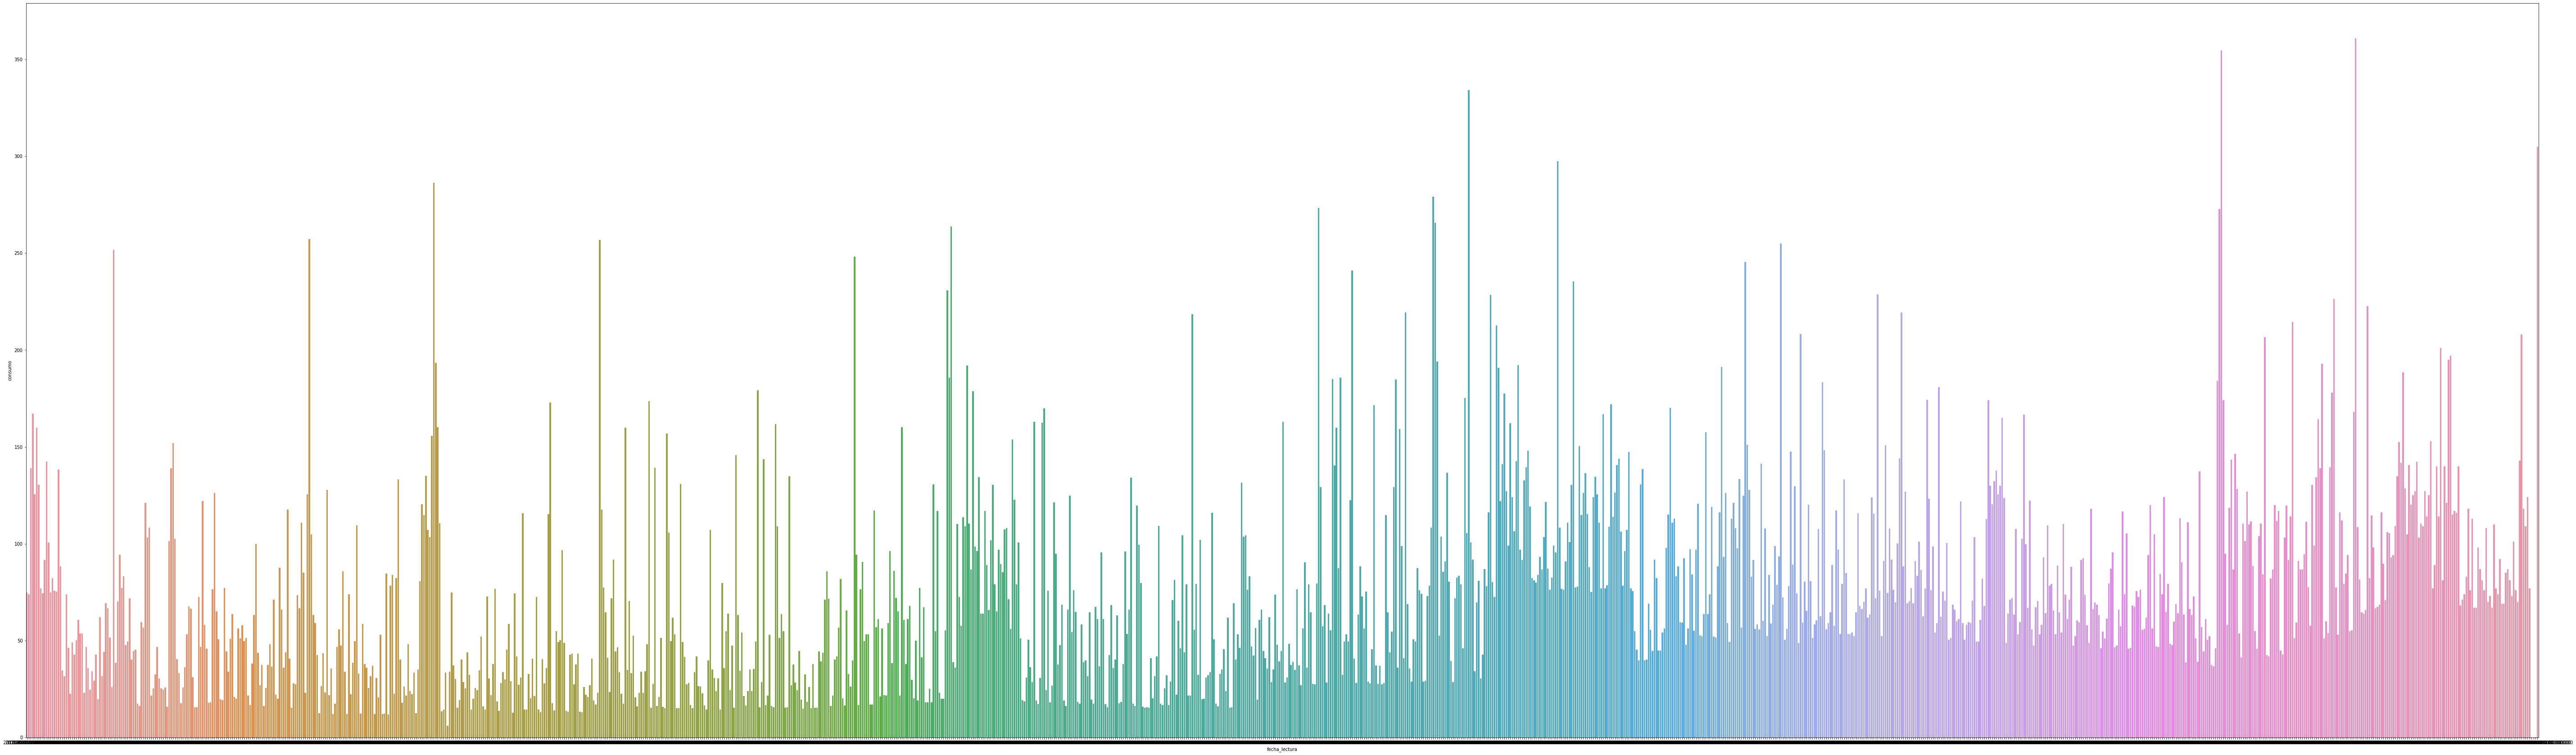

In [ ]:
fig, ax = plt.subplots(figsize = (100,30))
sns.barplot(x=contador.index, y='consumo', data=contador, ax=ax)

# Creación del dataframe para el knn

Guardamos el dataframe del consumo de un contador en un csv


In [ ]:
contador.to_csv('consumo_contador.csv')

## Creamos un dataframe para el KNN
El cual cada fila corresponde a los 7 ultimos dias de consumo de cada dia

In [ ]:
consumo_contador = pd.read_csv('consumo_contador.csv')

consumo_contador['fecha_lectura'] = pd.to_datetime(consumo_contador['fecha_lectura'])

lista_knn = []
for i in range(6,(len(consumo_contador)-4)):
  linea = [consumo_contador.iloc[i-6]['consumo'],
           consumo_contador.iloc[i-5]['consumo'],
           consumo_contador.iloc[i-4]['consumo'],
           consumo_contador.iloc[i-3]['consumo'],
           consumo_contador.iloc[i-2]['consumo'],
           consumo_contador.iloc[i-1]['consumo'],
           consumo_contador.iloc[i]['consumo']]
  lista_knn.append(linea)

df_knn = pd.DataFrame(lista_knn)

##Guardamos el dataframe en un csv

In [ ]:
df_knn.to_csv('df_knn.csv',index=False)

Eliminamos la ultima posisición del dataframe y la guardamos para predecir el conjunto mas parecido

In [ ]:
knn = pd.read_csv('df_knn.csv')

x_pred = np.array(knn.iloc[len(knn)-1]).reshape(1,-1)

knn.drop([0,len(knn)-1], inplace=True)

knn.tail()

,0,1,2,3,4,5,6
1256,87.0,81.0,73.0,101.0,76.0,70.0,143.0
1257,81.0,73.0,101.0,76.0,70.0,143.0,208.0
1258,73.0,101.0,76.0,70.0,143.0,208.0,118.0
1259,101.0,76.0,70.0,143.0,208.0,118.0,109.0
1260,76.0,70.0,143.0,208.0,118.0,109.0,124.0


# Predicción del algoritmo KNN y resultados

Predecimos el mejor vecino para el último día antes de fallar el contador.
En este caso nos da la posicion del dia más parecido, a la cual deberemos de agregarle 6 dias ya que los 6 primeros días no pudieron tomarse en cuenta para la prediccion ya que no habia datos suficientes para esos días.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 1)

model.fit(knn.values, knn.index)

y_pred= model.predict(x_pred)

fecha_i = consumo_contador.iloc[y_pred,:]['fecha_lectura'].values

fecha_i = fecha_i[0] + pd.Timedelta('6 days')

fecha_i

Timestamp('2017-10-08 00:00:00')

Recogemos los dias que nos faltan y veremos el consumo total para luego hacer una correlación con el consumo real de esos dias.

In [ ]:
fecha_f = fecha_i + pd.Timedelta( str(len(dias_faltantes)+1)+' days')

fecha_f

Timestamp('2017-10-12 00:00:00')

## Visualización de gráficos

Veremos la gráfica con los valores predichos para esos dias

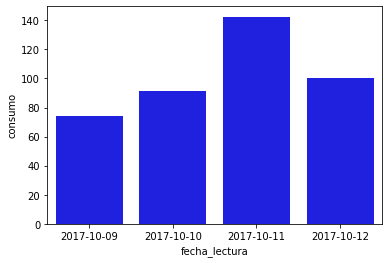

In [ ]:
dias_predichos = consumo_contador[(consumo_contador['fecha_lectura'] > fecha_i) & (consumo_contador['fecha_lectura'] <= fecha_f)]

sns.barplot(x=dias_predichos['fecha_lectura'].dt.date, y='consumo', data=dias_predichos, color='blue')

Calculamos el consumo total de dichos dias

In [ ]:
consumo_total = sum(dias_predichos['consumo'])

consumo_total

408.8000000000011

Establecemos la relación entre el consumo predicho y el consumo real

In [ ]:
Relacion = consumo_contador.iloc[-1]['consumo']/consumo_total

Relacion

0.7460861056751448

Creamos un array con el consumo real predicho

In [ ]:
consumo_real = dias_predichos['consumo']*Relacion
consumo_real = consumo_real.values

consumo_real

array([ 55.43419765,  68.26687867, 106.24266145,  75.05626223])

Aplicamos la relación y vemos el gráfico que debemos de añadir al consumo del contador

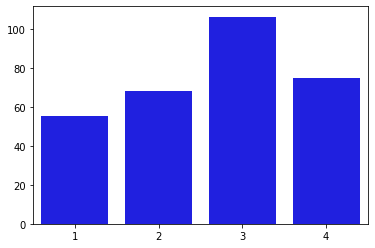

In [ ]:
dias = [x+1 for x in range(len(dias_predichos))]

sns.barplot(x=dias, y=consumo_real, color='blue')

Para finalizar cogemos dichos consumos y lo añadimos al dataframe en su respectiva posición

In [ ]:
indices_consumos_faltantes = np.array(consumo_contador[consumo_contador['fecha_lectura'] >= dias_faltantes[0]].index, dtype=int)

consumo_contador.iloc[indices_consumos_faltantes,2] = consumo_real
  
consumo_contador.tail(5)

,fecha_lectura,volumen_m3,consumo
1267,2021-03-21,105749.0,77.000000
1268,2021-03-22,NaN,55.434198
1269,2021-03-23,NaN,68.266879
1270,2021-03-24,NaN,106.242661
1271,2021-03-25,106054.0,75.056262
